<div style="text-align: right"> York University - ML1030 - Julia Mitroi </div>

# Sentiment Analysis for Movie Reviews

***

### Data description from Kaggle

"The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.

train.tsv contains phrases and their associated sentiment labels. We have additionally provided a SentenceId so that you can track which phrases belong to a single sentence.

test.tsv contains just phrases. You must assign a sentiment label to each phrase."

The sentiment labels are: <br>
<font color=blue>0 - negative, 1 - somewhat negative, 2 - neutral, 3 - somewhat positive, 4 - positive</font>

***

## Exploratory Data Analysis (EDA)

The purpose of EDA is to analyze the datasets to summarize their main characteristics, including through visualizations; to see what the data reveals beyond the modeling results.  This notebook outlines the EDA for the Movie Reviews data. 

### Installing libraries and packages

In [1]:
import os

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')



C:\Users\julia.mitroi\AppData\Local\Continuum\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia.mitroi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\julia.mitroi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Importing data into Python

In [2]:
train_reviews = pd.read_csv("train.tsv", sep="\t")

In [3]:
test_reviews = pd.read_csv("test.tsv", sep="\t")

### Descriptive statistics

In [4]:
# Displaying the first 5 rows in the training dataset, to visually examine the training data
train_reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
# Displaying the first 5 rows in the training dataset, to visually examine the test data
test_reviews.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [6]:
# Getting the shape (# of rows and columns) of train dataset
train_reviews.shape

(156060, 4)

In [7]:
# Getting the shape (# of rows and columns) of test dataset
test_reviews.shape

(66292, 3)

In [8]:
# Displaying the last 5 rows in the training dataset for Phrase, to visually examine these data
train_reviews['Phrase'].tail()

156055                    Hearst 's
156056    forced avuncular chortles
156057           avuncular chortles
156058                    avuncular
156059                     chortles
Name: Phrase, dtype: object

In [9]:
# Getting a concise summary of the train dataframe
train_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [10]:
# Getting a concise summary of the test dataframe
test_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [11]:
# Computing a summary of statistics pertaining to the train dataframe's columns
train_reviews.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


### Sentences and sentiments

In [12]:
# Examining sentence structure
# Function to print a random sentence from test set
def print_sample_sentence(train_reviews, sentence_id=None):
    if not sentence_id:
        # list of unique sentence IDs from the test set
        sentence_ids = test_reviews.SentenceId.unique()
        # pick a random sentences ID from the unique sentences in test
        sentence_id = np.random.choice(sentence_ids)
    print("Sentence ID = {}".format(sentence_id))
    return train_reviews[train_reviews.SentenceId == sentence_id].iloc[:].Phrase

print_sample_sentence(test_reviews)

Sentence ID = 9027


11593    The only excitement comes when the credits fin...
11594                                  The only excitement
11595                                      only excitement
11596    comes when the credits finally roll and you ge...
11597    comes when the credits finally roll and you ge...
11598    when the credits finally roll and you get to l...
11599    the credits finally roll and you get to leave ...
11600                         the credits finally roll and
11601                             the credits finally roll
11602                                          the credits
11603                                         finally roll
11604                                              finally
11605                                                 roll
11606                         you get to leave the theater
11607                             get to leave the theater
11608                                 to leave the theater
11609                                    leave the theat

In [13]:
# Printing the distinct sentence IDs from the train set
sentence_ids = train_reviews.SentenceId.unique()
print("Sentence IDs = {}".format(sentence_ids))

Sentence IDs = [   1    2    3 ... 8542 8543 8544]


In [14]:
# Number of unique sentence IDs from the train set
len(sentence_ids)

8529

In [15]:
# Checking for Nulls in train set
train_reviews.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [16]:
# Checking for Nulls in test set
train_reviews.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

No nulls in train or test sets.

In [17]:
# Assigning Sentiment labels to Sentiment numbers
Sentiment_labels=[]
for row in train_reviews['Sentiment']:
    if row ==0:
        Sentiment_labels.append('0 - negative')
    elif row == 1:
        Sentiment_labels.append('1 - somewhat negative')
    elif row == 2:
        Sentiment_labels.append('2 - neutral')
    elif row == 3:
        Sentiment_labels.append('3 - somewhat positive')
    elif row == 4:
        Sentiment_labels.append('4 - positive')
    else:
        Sentiment_labels.append('Null')
train_reviews['Sentiment_label'] = Sentiment_labels

In [18]:
# Label counts in training set
count=pd.value_counts(train_reviews['Sentiment_label'].values, sort=False)
count

3 - somewhat positive    32927
0 - negative              7072
1 - somewhat negative    27273
2 - neutral              79582
4 - positive              9206
dtype: int64

### Vizualizations
Creating and studying the visual representation of Sentiment data.

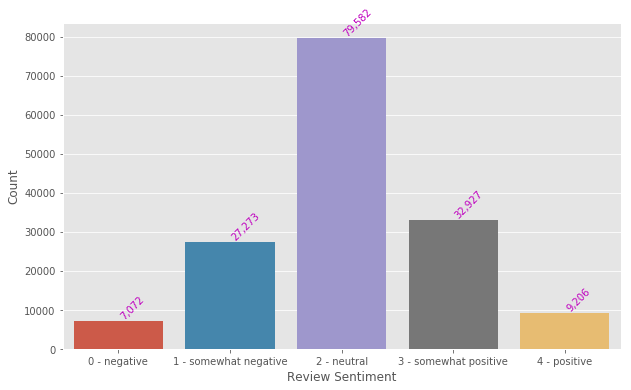

In [19]:
# Bar chart of Sentiment counts
dist = train_reviews.groupby(["Sentiment_label"]).size()
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(dist.keys(), dist.values);
ax.set(xlabel="Review Sentiment", ylabel='Count')
for i, v in enumerate(dist.iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', 
    rotation=45)

Sentiment classes follow a normal distribution, with the most frequently distributed class being "2", "neutral". This type of distribution could lead to a model not having sufficient data to learn the less-represented classes, and is something to be aware of when evaluating a model applied to data.

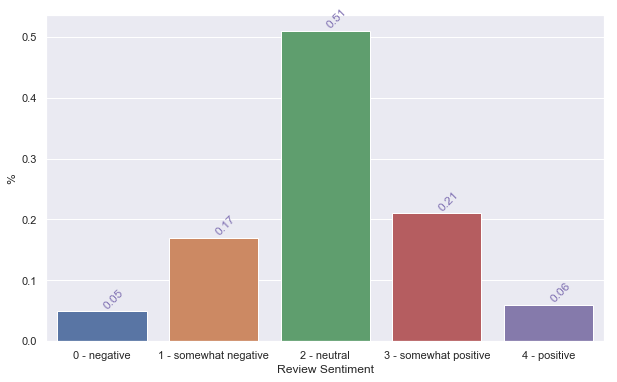

In [20]:
# Bar chart of Sentiment proportions
sns.set(color_codes=True)
dist = train_reviews.groupby(["Sentiment_label"]).size()
dist = round(dist / dist.sum(), 2)
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(dist.keys(), dist.values)
ax.set(xlabel="Review Sentiment", ylabel='%')
for i, v in enumerate(dist.iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', 
    rotation=45)

### Phrase length

Measuring phrase length is done because some algorithms take fixed shape inputs, and it may be necessary to pad the phrases to have equal sizes. This also gives an idea on the of sentences in the corpus.

[Text(0.5, 0, 'Text length')]

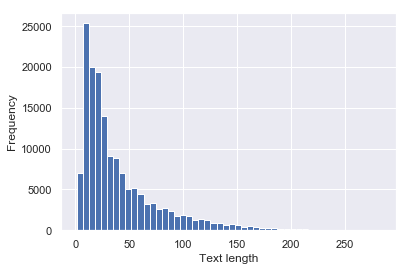

In [21]:
# Histogram: Phrase fequency by phrase length for entire training set
train_reviews['text_length']=train_reviews['Phrase'].apply(len)
ax = train_reviews['text_length'].plot.hist(bins=50)
ax.set(xlabel="Text length")

In [22]:
# Checking that new column has been added
train_reviews.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_label,text_length
0,1,1,A series of escapades demonstrating the adage ...,1,1 - somewhat negative,188
1,2,1,A series of escapades demonstrating the adage ...,2,2 - neutral,77
2,3,1,A series,2,2 - neutral,8
3,4,1,A,2,2 - neutral,1
4,5,1,series,2,2 - neutral,6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF49C17828>,
      dtype=object)

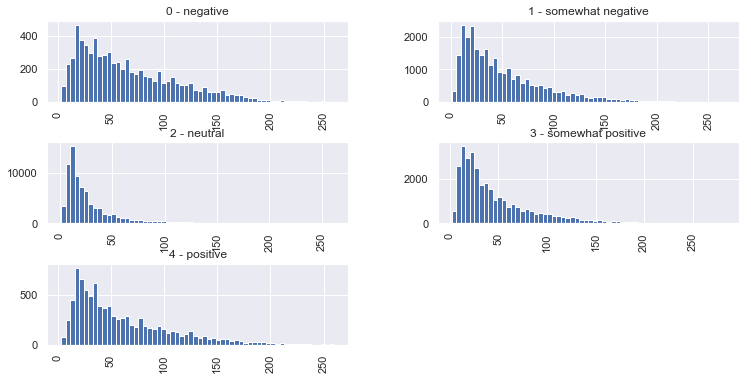

In [23]:
# Histograms: Phrase fequency by phrase length by Sentiment subset
train_reviews.hist(column='text_length', by='Sentiment_label', bins=60, figsize=(12,6))

In [24]:
# Average length of phrase text in train set
train_reviews['text_length'].describe()
# Mean text length for training set is 40 characters

count    156060.000000
mean         40.217224
std          38.154130
min           1.000000
25%          14.000000
50%          26.000000
75%          53.000000
max         283.000000
Name: text_length, dtype: float64

In [25]:
# Length of longest phrase in train set
train_reviews['text_length'].max()
# Mean phrase length for training set is 283 characters

283

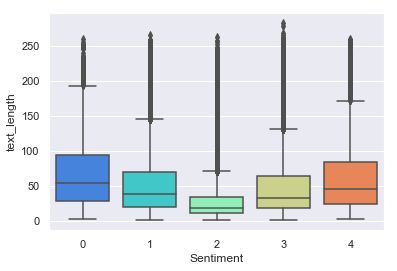

In [26]:
# Box plot of text length by Sentiment
sns.boxplot(x='Sentiment',y='text_length',data=train_reviews, palette='rainbow')

In [27]:
# Quantiles - return values at the given quantile for text_length
print(train_reviews['text_length'].quantile([i*0.1 for i in range(11)]))

0.0      1.0
0.1      9.0
0.2     12.0
0.3     16.0
0.4     20.0
0.5     26.0
0.6     34.0
0.7     45.0
0.8     63.0
0.9     94.0
1.0    283.0
Name: text_length, dtype: float64


The figures above show that 20% of the phrases in the train set have 12 characters or less (mainly parts of sentences) 
and 80% of them have 63 characters or less. The longest sentence has 283 characters. 

For data pre-processing for modeling, all sentences can be padded to have the same phrase length, or can choose to drop all the characters after a certain length.

In [28]:
# Another way of getting lengths of phrases, in words vs. characters.
# Get the word length of each Phrase to assess if it has an effect on Sentiment rating
train_reviews['words_length'] = train_reviews['Phrase'].apply(lambda x: len(str(x).split(' ')))
train_reviews['words_length'].unique()

array([37, 14,  2,  1, 12, 11, 10,  3,  7,  6,  5,  4, 23, 22, 20, 19, 18,
       15,  9,  8, 21, 26, 25, 16, 13, 17, 30, 28, 27, 24, 41, 40, 36, 29,
       31, 32, 34, 33, 42, 39, 38, 35, 43, 45, 44, 49, 48, 47, 46, 51, 50,
       52], dtype=int64)

In [29]:
# Word frequencies
sentences = ' '.join(train_reviews.Phrase.values)
counts = dict(Counter(sentences.split(' ')))  # splitting phrases by spaces
counts = pd.DataFrame([counts.keys() , counts.values()]).T.sort_values(1 , ascending = False).reset_index(drop = True)

# 20 most frequent and less frequent words:
print(counts.head(20))
# 20 least frequent and less frequent words:
print(counts.tail(20))

        0      1
0     the  46552
1       ,  42006
2       a  33443
3      of  32245
4     and  31695
5      to  22363
6       .  17565
7      's  16971
8      in  13523
9      is  13340
10   that  12175
11     it  10358
12     as   8415
13   with   7568
14    for   7273
15    its   6947
16   film   6626
17     an   5929
18  movie   5827
19   this   5064
                     0  1
18207         Horrible  1
18208      Undoubtedly  1
18209             Luis  1
18210           Begins  1
18211      Contradicts  1
18212          casings  1
18213           Roland  1
18214           Lazily  1
18215  Compassionately  1
18216             Arty  1
18217     Predecessors  1
18218           Gently  1
18219            Leaks  1
18220          Weirdly  1
18221          Largely  1
18222           Wobbly  1
18223             Plus  1
18224    One-of-a-kind  1
18225     Staggeringly  1
18226        Curiously  1


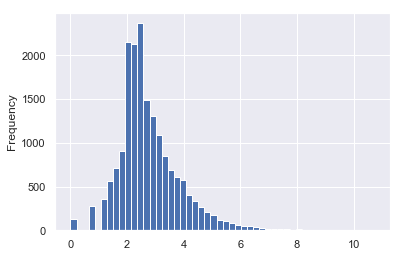

In [30]:
# Distribution of the log of the number of occurences per word:
counts[1].apply(lambda x:np.log(x)).plot.hist(bins = 50)

The chart shows that there is a non-negligible amount of words that have very low occurrence (either rarely used words, numbers, or misspellings). Traditionally, those words are known to easily lead to overfitting and are generally removed from the dataset; however, as I also intend to use pre-trained word embeddings (GloVe), I will keep these words in the analysis.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from nltk.corpus import stopwords
# Most frequent words in test set: This could be informative on whether to use STOP WORDS or not in the modeling task
stop_word = set(stopwords.words('english')) 
word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word', min_df=0.001)
sparse_matrix = word_vectorizer.fit_transform(test_reviews['Phrase'])
frequencies = sum(sparse_matrix).toarray()[0]
freq = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
freq.sort_values('frequency', ascending=False)

,frequency
the,20181
and,12594
of,12508
to,9142
in,5658
is,5322
it,4857
that,4531
as,3366
with,2972


### Correlations

Examining correlation between Sentiment and phrase length.
There does not appear to be a significant correlation between Sentiment and phrase length, meaning that the length of a phrase or movie review does not influence the reviewer's Sentiment.

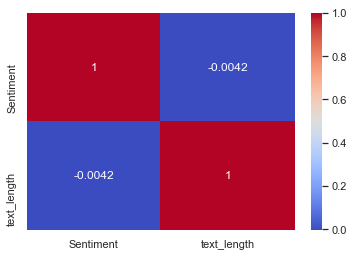

In [32]:
sns.heatmap(train_reviews[['Sentiment','text_length']].corr(), annot = True, cmap='coolwarm')

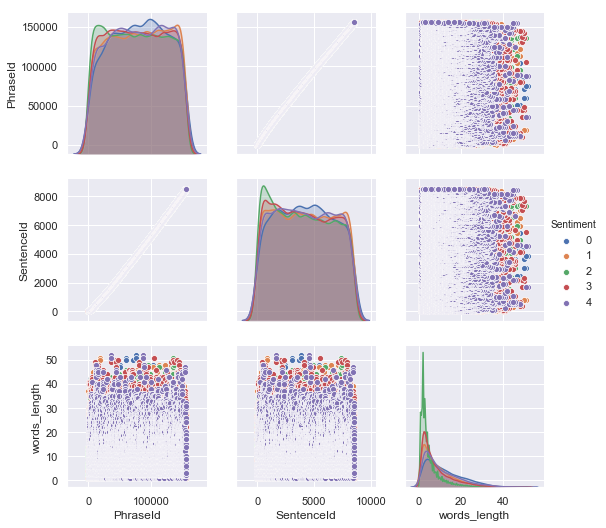

In [33]:
# Plotting pairwise relationships between Phrase ID, Sentence ID, and Phrase Length in the train_reviews dataset to see
# if there is a relationship between Phrase and Sentence ID and/or Phrase Length 
# As the goal of the project is to output PhraseID and Sentiment only, a pairplot may reveal some patterns.
sns.pairplot(train_reviews,hue='Sentiment',vars=['PhraseId','SentenceId','words_length'])

# The functions outputs scatterplots for joint relationships and density plots for the univariate distributions
# The density plots are a variation of histograms.

The univariate distributions of Phrase ID, Sentence ID, and phrase length depict that the 5 Sentiments are distributed uniformly across the train dataset, from the lowest to the highest phrase and sentence IDs, for all 5 Sentiments; and that the univariate distribution for words (phrase) length is skewed towards shorter phrases, with the neutral Sentiment having the highest number of short phrases, it also having the highest count of rows/reviews in the dataset (as shown in the bar graphs above). The joint Phrase ID-phrase length and Sentence ID-phrase length relationships depict that both short and long phrases exist in the dataset across the entire range of IDs.

### Vocabulary analysis
A look at the whole vocabulary, as well as how it changes from one sentiment to another.

In [34]:
sentences = ' '.join(train_reviews.Phrase.values)
print('Total number of unique words in the train dataset:' , len(set(sentences.split(' '))))

Total number of unique words in the train dataset: 18227


In [35]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [36]:
# Counts of unique words for each Sentiment
for label in range(5):
    
    print('vocabulary for label :' , label)
    sub_sentences = ' '.join(train_reviews.loc[train_reviews.Sentiment == label, 'Phrase'].values)
    print('total number of unique words :' , len(set(sub_sentences.split(' '))))

vocabulary for label : 0
total number of unique words : 7682
vocabulary for label : 1
total number of unique words : 13401
vocabulary for label : 2
total number of unique words : 17359
vocabulary for label : 3
total number of unique words : 13545
vocabulary for label : 4
total number of unique words : 7759


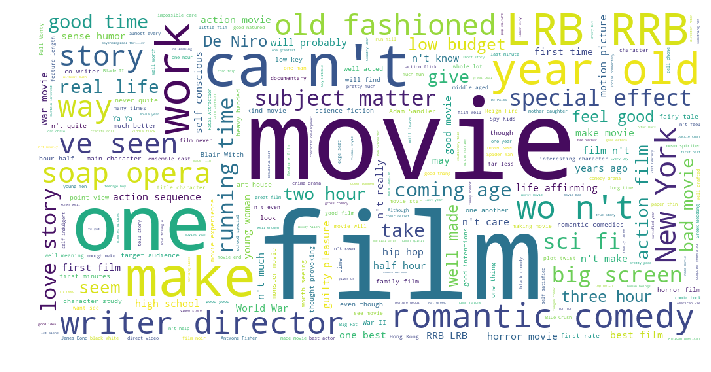

In [37]:
# Word cloud for entire train dataset
wc = WordCloud(background_color='white', width=1024, height=512,
                   max_words=1000, stopwords=stopwords, margin=10,
                   random_state=1).generate(sentences)
plt.figure(figsize=(12 , 30))
plt.imshow(wc)
plt.axis('off')
plt.show()

The WordCloud on the train data reveals that words or pairs of words such as “movie", “film", “romantic comedy", “soap opera", "feel good", "old fashioned", “New York", “writer", and "director" have the highest frequency in the review phrases' text.

vocabulary for label : 0
total number of unique words : 7682


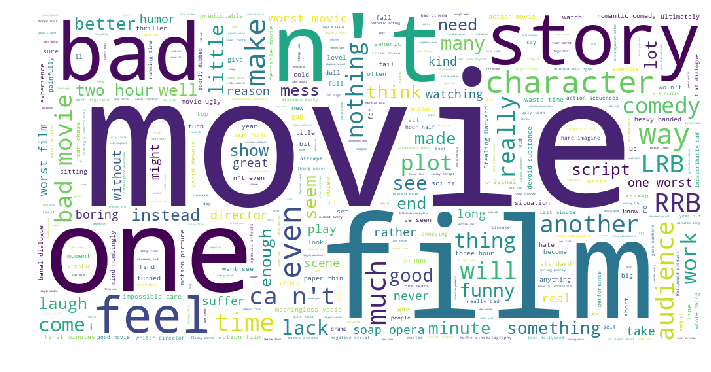

In [38]:
# Word cloud for Sentiment 0 ("negative" sentiment)
label = 0
print('vocabulary for label :' , label)
sub_sentences = ' '.join(train_reviews.loc[train_reviews.Sentiment == label, 'Phrase'].values)
print('total number of unique words :' , len(set(sub_sentences.split(' '))))
wc = WordCloud(background_color='white', width=1024, height=512,
                max_words=1000, stopwords=stopwords, margin=10,
                random_state=1).generate(sub_sentences)

plt.figure(figsize=(12 , 30))
plt.imshow(wc)
plt.axis('off')
plt.show()

vocabulary for label : 1
total number of unique words : 13401


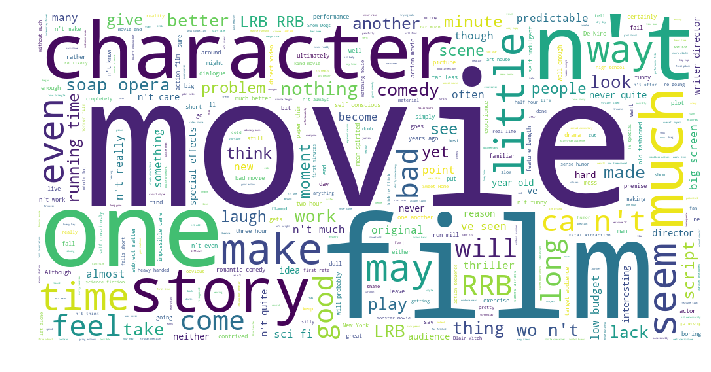

In [39]:
# Word cloud for Sentiment 1 ("somewhat negative" sentiment)
label = 1
print('vocabulary for label :' , label)
sub_sentences = ' '.join(train_reviews.loc[train_reviews.Sentiment == label, 'Phrase'].values)
print('total number of unique words :' , len(set(sub_sentences.split(' '))))
wc = WordCloud(background_color='white', width=1024, height=512,
                max_words=1000, stopwords=stopwords, margin=10,
                random_state=1).generate(sub_sentences)

plt.figure(figsize=(12 , 30))
plt.imshow(wc)
plt.axis('off')
plt.show()

vocabulary for label : 2
total number of unique words : 17359


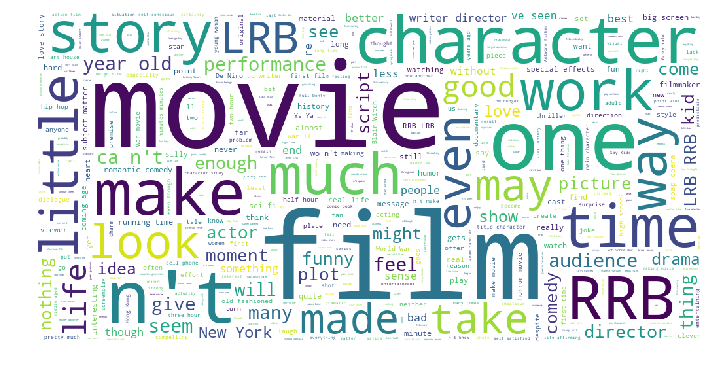

In [40]:
# Word cloud for Sentiment 2 dataset ("neutral" sentiment)
label = 2
print('vocabulary for label :' , label)
sub_sentences = ' '.join(train_reviews.loc[train_reviews.Sentiment == label, 'Phrase'].values)
print('total number of unique words :' , len(set(sub_sentences.split(' '))))
wc = WordCloud(background_color='white', width=1024, height=512,
                max_words=1000, stopwords=stopwords, margin=10,
                random_state=1).generate(sub_sentences)

plt.figure(figsize=(12 , 30))
plt.imshow(wc)
plt.axis('off')
plt.show()

vocabulary for label : 3
total number of unique words : 13545


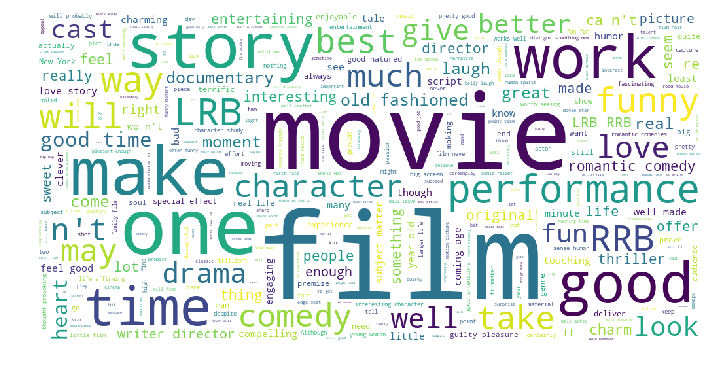

In [41]:
# Word cloud for Sentiment 3 dataset ("somewhat positive" sentiment)
label = 3
print('vocabulary for label :' , label)
sub_sentences = ' '.join(train_reviews.loc[train_reviews.Sentiment == label, 'Phrase'].values)
print('total number of unique words :' , len(set(sub_sentences.split(' '))))
wc = WordCloud(background_color='white', width=1024, height=512,
                max_words=1000, stopwords=stopwords, margin=10,
                random_state=1).generate(sub_sentences)

plt.figure(figsize=(12 , 30))
plt.imshow(wc)
plt.axis('off')
plt.show()

vocabulary for label : 4
total number of unique words : 7759


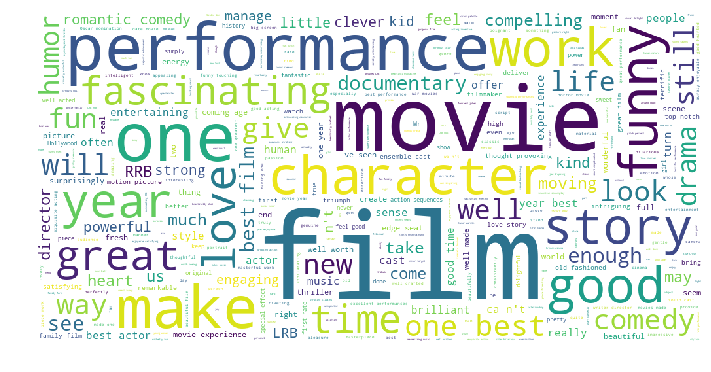

In [42]:
# Word cloud for Sentiment 4 dataset ("positive" sentiment)
label = 4
print('vocabulary for label :' , label)
sub_sentences = ' '.join(train_reviews.loc[train_reviews.Sentiment == label, 'Phrase'].values)
print('total number of unique words :' , len(set(sub_sentences.split(' '))))
wc = WordCloud(background_color='white', width=1024, height=512,
                max_words=1000, stopwords=stopwords, margin=10,
                random_state=1).generate(sub_sentences)

plt.figure(figsize=(12 , 30))
plt.imshow(wc)
plt.axis('off')
plt.show()

Visual examination of the word clouds shows that, as expected, vocabulary for Sentiments 0 and 1 ("negative" and "somewhat negative") have more words with negative connotation, such as "bad", "little", "nothing, "lack"; and vocabulary for Sentiments 3 and 4 ("somewhat positive" and "positive") have more words with positive connotation, such as "best", "good", "well", "fascinating", and "fun".

Based on the size of the words in the word clouds, vocabulary size of each class follows the trend of the number of sentences depicted in the counts and bar charts above, namely reduced vocabulary for Sentiments 0 and 4. The models built for classification might consequently have to rely more on the order of the words in the sentences versus the vocabulary to differentiate between a negative statement and somewhat negative statement.